In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from rff.layers import GaussianEncoding #pip install random-fourier-features-pytorch
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import os
import optuna
from optuna.trial import TrialState

c:\Users\prime\anaconda3\envs\DL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Run regardless if you do or do not have GPU so all tensors are moved to right location later on
if torch.cuda.is_available():
    device_in_use = torch.device("cuda")
    print("GPU is available and being used")
else:
    device_in_use = torch.device("cpu")
    print("GPU is not available, using CPU instead")

device_in_use='cpu'

GPU is not available, using CPU instead


# LOAD AND PROCESS DATA
**EXAMPLE WITH COVTYPE DATASET**
1. Standardize or perform quantile transformations to numerical/continuous features.
1. Wrap with Dataset and Dataloader.

In [4]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')
df_val = pd.read_csv('./data/validation.csv') #READ FROM RIGHT SPOT

#Take a look at what the datasets look like initially to get an idea
df_train

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,1.261189,-0.764261,-0.358478,0.584211,0.643412,0.431828,0.688976,-0.627034,1.0,-0.786025
1,-0.906340,1.384381,0.355019,0.401362,0.681233,0.077837,0.741252,-0.993331,1.0,-0.764461
2,-1.425748,1.000528,1.861291,-0.415056,-0.361193,-0.698186,-0.372218,-0.104586,3.0,2.523613
3,0.581963,-0.689363,0.196464,0.115662,0.258117,0.173441,0.362254,-0.108109,0.0,1.104704
4,0.936559,-0.736174,0.037909,-0.620761,-0.599934,-0.179689,-0.476769,-0.674510,1.0,-0.630765
...,...,...,...,...,...,...,...,...,...,...
12254,0.806707,-0.904695,-0.358478,0.163202,-0.086995,0.010657,-0.118681,0.814126,0.0,0.569055
12255,1.021462,-0.885971,-1.864750,1.468283,1.177626,1.579069,1.313670,0.481794,0.0,-0.402187
12256,0.581963,-0.768942,1.068516,-0.475396,-0.396649,-0.407070,-0.356535,-0.410684,0.0,1.103841
12257,-1.225976,0.897543,-1.309808,1.410229,1.246175,1.732379,1.460041,0.740152,3.0,0.205055


In [5]:
#Take a look at the feature names
print(df_train.columns)
target = 'median_house_value'

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity', 'median_house_value'],
      dtype='object')


In [6]:
def categorize_columns(dataframe):
    categorical_columns = []
    continuous_columns = []
    unique_classes_per_column = []  # To hold the number of unique classes for each categorical column

    for column in dataframe.columns:
        if dataframe[column].dtype == 'object' or len(dataframe[column].unique()) <= 10:
            # If the column's data type is 'object' or it has 10 or fewer unique values, consider it categorical.
            categorical_columns.append(column)
            unique_classes_per_column.append(dataframe[column].nunique())  # Store the number of unique classes
        else:
            # Otherwise, consider it continuous.
            continuous_columns.append(column)

    return categorical_columns, continuous_columns, unique_classes_per_column

In [7]:
cat_cols, cont_cols, unique_classes_per_column = categorize_columns(df_train)

if target in cont_cols:
    cont_cols.remove(target)
elif target in cat_cols:
    cat_cols.remove(target)

print("Target:", target)
print("Categorical: ", cat_cols)
print("Continous: ", cont_cols)
print("Unique Classes per Column: ", unique_classes_per_column)


Target: median_house_value
Categorical:  ['ocean_proximity']
Continous:  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
Unique Classes per Column:  [5]


In [8]:
class SingleTaskDataset(Dataset):
    def __init__(self, df : pd.DataFrame, cat_columns, num_columns,task1_column):
        self.n = df.shape[0]
        
        self.task1_labels = df[task1_column].astype(np.float32).values

        self.cate = df[cat_columns].astype(np.int64).values
        self.num = df[num_columns].astype(np.float32).values


    def __len__(self):
        return self.n
    
    def __getitem__(self, idx):
        # Retrieve features and labels from the dataframe using column names
        cat_features = self.cate[idx]
        num_features = self.num[idx]
        labels_task1 = self.task1_labels[idx]

        return cat_features, num_features, labels_task1

#Wrapping in Dataset
train_dataset = SingleTaskDataset(df_train, cat_cols, cont_cols, 'median_house_value')
val_dataset = SingleTaskDataset(df_val, cat_cols, cont_cols, 'median_house_value')
test_dataset = SingleTaskDataset(df_test, cat_cols, cont_cols, 'median_house_value')

#This is a hyperparameter that is not tuned. Maybe mess with what makes sense here
#Also try looking to see what other papers have done
batch_size = 256

# Wrapping with DataLoader for easy batch extraction
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# MODEL AND HELPERS

1. All you should have to do is interact with Classifier()

In [9]:
# each task loss is scaled by its own learnable parameter, then regularization is applied 
class UncertaintyLoss(nn.Module):
    def __init__(self, num_tasks):
        super(UncertaintyLoss, self).__init__()
        self.num_tasks = num_tasks

        self.loss_fns = [nn.MSELoss() for x in range(num_tasks)] 

    def forward(self, predictions, labels_task1):

        target = labels_task1
        prediction = predictions[0].squeeze(1)
        loss_fn = self.loss_fns[0]

        task_loss = loss_fn(prediction, target)
        
        return task_loss
    
#All layers of the model
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(MultiHeadAttention, self).__init__()

        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads
        assert(self.head_dim * heads == embed_size), "Embed size needs to be div by heads"
        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys =nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads*self.head_dim, embed_size)


    def forward(self, values, keys, query):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])

        attention = torch.softmax(energy / (self.embed_size ** (1/2)), dim=3) #(batch_size, head_dim, #query_embeddings, #key_embeddings)

        # Calculate simplified attention scores
        avg_attention = attention.mean(dim=0)  # Average across batches
        # print("batch average", avg_attention.shape)
        avg_attention = avg_attention.mean(dim=0).squeeze(dim=0)
        # print("head average", avg_attention.shape)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(N, query_len, self.heads*self.head_dim) #(batch_size, n_features, embed_size)
        out = self.fc_out(out)

        return out, avg_attention
    
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion, pre_norm_on):
        super(TransformerBlock, self).__init__()

        self.pre_norm_on = pre_norm_on
        if self.pre_norm_on:
            self.pre_norm = nn.LayerNorm(embed_size)
        self.attention = MultiHeadAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(nn.Linear(embed_size, forward_expansion*embed_size),
                                          nn.ReLU(),
                                          nn.Linear(forward_expansion*embed_size, embed_size)
                                          )
        self.dropout = nn.Dropout(dropout)

    def forward(self,value,key,query):
        if self.pre_norm_on:
            query = self.pre_norm(query)
            key = self.pre_norm(key)
            value = self.pre_norm(value)
            
        attention, avg_attention = self.attention(value, key, query)
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out, avg_attention
    
class DecoderBlock(nn.Module):
    def __init__(self, embed_size, heads, forward_expansion, dropout, pre_norm_on):
        super(DecoderBlock, self).__init__()

        self.attention = MultiHeadAttention(embed_size, heads)
        self.norm = nn.LayerNorm(embed_size)
        self.transformer_block = TransformerBlock(embed_size, heads, dropout, forward_expansion, pre_norm_on)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, value, key):
        out, avg_attention = self.transformer_block(value, key, x)

        return out, avg_attention

class Decoder(nn.Module):
    def __init__(self,
                 embed_size,
                 num_layers,
                 heads,
                 forward_expansion,
                 decoder_dropout,
                 pre_norm_on
    ):
        super(Decoder, self).__init__()

        self.layers = nn.ModuleList(
                [
                    DecoderBlock(
                        embed_size,
                        heads,
                        dropout=decoder_dropout,
                        forward_expansion=forward_expansion,
                        pre_norm_on=pre_norm_on
                    )
                    for _ in range(num_layers)
                ]
            )
        self.avg_attention = None

    def forward(self, class_embed, context):
        for layer in self.layers:
            # x is the classification embedding (CLS Token)
            # context are the feature embeddings that will be used as key and value
            x, self.avg_attention = layer(class_embed, context, context)
  
        return x 

class Embeddings(nn.Module):
    def __init__(self, sigma, embed_size, input_size, embedding_dropout, n_cont, cat_feat, num_target_labels, rff_on):
        super(Embeddings, self).__init__()

        self.rff_on = rff_on

        if self.rff_on:
            self.rffs = nn.ModuleList([GaussianEncoding(sigma=sigma, input_size=input_size, encoded_size=embed_size//2) for _ in range(n_cont)])
            self.dropout = nn.Dropout(embedding_dropout)
            self.mlp_in = embed_size
        else:
            self.mlp_in = input_size

        self.cont_embeddings = nn.ModuleList([nn.Linear(in_features=self.mlp_in, out_features=embed_size) for _ in range(n_cont)])

        self.cat_embeddings = nn.ModuleList([nn.Embedding(num_classes, embed_size) for num_classes in cat_feat])

        # Classifcation Embeddings for each target label
        self.target_label_embeddings = nn.ModuleList([nn.Embedding(1, embed_size) for _ in range(num_target_labels)])


    def forward(self, cat_x, cont_x):
        x = cont_x.unsqueeze(2) #(batch_size, n_features) -> (batch_size, n_features, 1)
        rff_vectors = []
        if self.rff_on:
            for i, r in enumerate(self.rffs):
                input = x[:,i,:]
                out = r(input)
                rff_vectors.append(out)
        
            x = torch.stack(rff_vectors, dim=1)
        
        embeddings = []
        for i, e in enumerate(self.cont_embeddings):
            goin_in = x[:,i,:]
            goin_out = e(goin_in)
            embeddings.append(goin_out)

        #embedding cat features
        cat_x = cat_x.unsqueeze(2)
        for i, e in enumerate(self.cat_embeddings):

            goin_in = cat_x[:,i,:]
  
            goin_out = e(goin_in)
            goin_out=goin_out.squeeze(1)
            embeddings.append(goin_out)

        target_label_embeddings_ = []
        for e in self.target_label_embeddings:
            input = torch.tensor([0], device=x.device)
            temp = e(input)
            temp = temp.repeat(x.size(0), 1)
            tmep = temp.unsqueeze(1)
            target_label_embeddings_.append(temp)

        class_embeddings = torch.stack(target_label_embeddings_, dim=1)

        context = torch.stack(embeddings, dim=1)

        return class_embeddings, context

class classificationHead(nn.Module):
    def __init__(self, embed_size, dropout, mlp_scale_classification, num_target_classes):
        super(classificationHead, self).__init__()
        
        #flattening the embeddings out so each sample in batch is represented with a 460 dimensional vector
        self.input = embed_size
        self.lin1 = nn.Linear(self.input, mlp_scale_classification*self.input)
        self.drop = nn.Dropout(dropout)
        self.lin2 = nn.Linear(mlp_scale_classification*self.input, mlp_scale_classification*self.input)
        self.lin3 = nn.Linear(mlp_scale_classification*self.input, self.input)
        self.lin4 = nn.Linear(self.input, num_target_classes)
        self.relu = nn.ReLU()
        self.initialize_weights()

    def initialize_weights(self): #he_initialization.
        torch.nn.init.kaiming_normal_(self.lin1.weight, nonlinearity='relu')
        torch.nn.init.zeros_(self.lin1.bias)

        torch.nn.init.kaiming_normal_(self.lin3.weight, nonlinearity='relu')
        torch.nn.init.zeros_(self.lin3.bias)

    def forward(self, x):

        x= torch.reshape(x, (-1, self.input))

        x = self.lin1(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.lin2(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.lin3(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.lin4(x)
  
        return x

class Classifier(nn.Module):
    def __init__(self, 
                 rff_on = False,
                 sigma=4,
                 embed_size=20,
                 input_size=1,
                 embedding_dropout = 0,
                 n_cont = 0,
                 cat_feat:list = [],
                 num_layers=1,
                 heads=1,
                 forward_expansion=4, # Determines how wide the MLP is in the encoder. Its a scaling factor. 
                 decoder_dropout=0,
                 classification_dropout = 0,
                 pre_norm_on = False,
                 mlp_scale_classification = 4,
                 targets_classes : list=  [3,8]
                 ):
        super(Classifier, self).__init__()

        self.embeddings = Embeddings(rff_on=rff_on, sigma=sigma, embed_size=embed_size, input_size=input_size, 
                                     embedding_dropout=embedding_dropout,n_cont=n_cont, cat_feat=cat_feat, num_target_labels=len(targets_classes))
        self.decoder = Decoder(embed_size=embed_size, num_layers=num_layers, heads=heads, forward_expansion=forward_expansion, 
                               decoder_dropout=decoder_dropout, pre_norm_on=pre_norm_on)
        self.classifying_heads = nn.ModuleList([classificationHead(embed_size=embed_size, dropout=classification_dropout, 
                                                                   mlp_scale_classification=mlp_scale_classification, 
                                                                   num_target_classes=x) for x in targets_classes])
        
    def forward(self, cat_x, cont_x):
        class_embed, context = self.embeddings(cat_x, cont_x)

        x = self.decoder(class_embed, context)
        
        probability_dist_raw = []
        for i, e in enumerate(self.classifying_heads):
            input = x[:, i,:]
            output = e(input)
            probability_dist_raw.append(output)
        
        return probability_dist_raw

# Training and Testing Loops
def train(dataloader, model, loss_function, optimizer, device_in_use):
    model.train()

    total_loss = 0
    total_r2_score = 0
    root_mean_squared_error_total = 0

    for (x_cat, x_cont, labels_task1) in dataloader:
        x_cat, x_cont, labels_task1 = x_cat.to(device_in_use), x_cont.to(device_in_use), labels_task1.to(device_in_use)

        task_predictions = model(x_cat, x_cont)
        
        loss = loss_function(task_predictions, labels_task1)
        total_loss += loss.item()
        
        # Calculate R^2 score for the regression task
        r2 = r2_score_manual(labels_task1, task_predictions[0].squeeze(1))
        total_r2_score += r2

        # Calculate RMSE score for the regression task
        rmse_value = rmse(labels_task1, task_predictions[0].squeeze(1))
        root_mean_squared_error_total+=rmse_value

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_loss = total_loss / len(dataloader)
    avg_r2_score = total_r2_score / len(dataloader)
    avg_rmse_score = root_mean_squared_error_total / len(dataloader)

    return avg_loss, avg_r2_score, avg_rmse_score

def test(dataloader, model, loss_function, device_in_use):
  model.eval()
  total_loss = 0
  
  total_loss = 0
  total_r2_score = 0
  root_mean_squared_error_total = 0

  with torch.no_grad():
    for (x_cat, x_cont, labels_task1) in dataloader:
        x_cat, x_cont, labels_task1 = x_cat.to(device_in_use), x_cont.to(device_in_use), labels_task1.to(device_in_use)

        task_predictions = model(x_cat, x_cont)

        loss = loss_function(task_predictions, labels_task1)
        total_loss += loss.item()
        
        # Calculate R^2 score for the regression task
        r2 = r2_score_manual(labels_task1, task_predictions[0].squeeze(1))
        total_r2_score += r2
        
        # Calculate RMSE score for the regression task
        rmse_value = rmse(labels_task1, task_predictions[0].squeeze(1))
        root_mean_squared_error_total+=rmse_value

    avg_loss = total_loss / len(dataloader)
    avg_r2_score = total_r2_score / len(dataloader)
    avg_rmse_score = root_mean_squared_error_total / len(dataloader)

    return avg_loss, avg_r2_score, avg_rmse_score

def format_metric(value): # Used to format the metrics output
    return f"{value:.4f}"

def r2_score_manual(y_true, y_pred):
    # Calculate the mean of true labels
    y_mean = torch.mean(y_true)

    # Calculate the total sum of squares
    total_ss = torch.sum((y_true - y_mean)**2)

    # Calculate the residual sum of squares
    residual_ss = torch.sum((y_true - y_pred)**2)

    # Calculate R-squared
    r2 = 1 - (residual_ss / total_ss)

    return r2.item()  # Convert to a Python float

def rmse(y_true, y_pred):
    # Calculate the squared differences
    squared_diff = (y_true - y_pred)**2

    # Calculate the mean of the squared differences
    mean_squared_diff = torch.mean(squared_diff)

    # Calculate the square root to obtain RMSE
    rmse = torch.sqrt(mean_squared_diff)

    return rmse.item()  # Convert to a Python float

In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Number of parameters:  5343521
Epoch [ 1/100]       | Train: Loss 0.8177, R2 0.1810, RMSE 0.9010                        | Test: Loss 0.6625, R2 0.3365, RMSE 0.8126
Epoch [ 2/100]       | Train: Loss 0.5613, R2 0.4353, RMSE 0.7466                        | Test: Loss 0.4642, R2 0.5314, RMSE 0.6798
Epoch [ 3/100]       | Train: Loss 0.4291, R2 0.5681, RMSE 0.6527                        | Test: Loss 0.3662, R2 0.6318, RMSE 0.6041
Epoch [ 4/100]       | Train: Loss 0.3513, R2 0.6468, RMSE 0.5909                        | Test: Loss 0.3286, R2 0.6698, RMSE 0.5713
Epoch [ 5/100]       | Train: Loss 0.3109, R2 0.6875, RMSE 0.5560                        | Test: Loss 0.2858, R2 0.7115, RMSE 0.5340
Epoch [ 6/100]       | Train: Loss 0.2801, R2 0.7178, RMSE 0.5281                        | Test: Loss 0.2877, R2 0.7112, RMSE 0.5342
Epoch [ 7/100]       | Train: Loss 0.2792, R2 0.7192, RMSE 0.5269                        | Test: Loss 0.2638, R2 0.7343, RMSE 0.5125
Epoch [ 8/100]       | Train: Loss 0.2

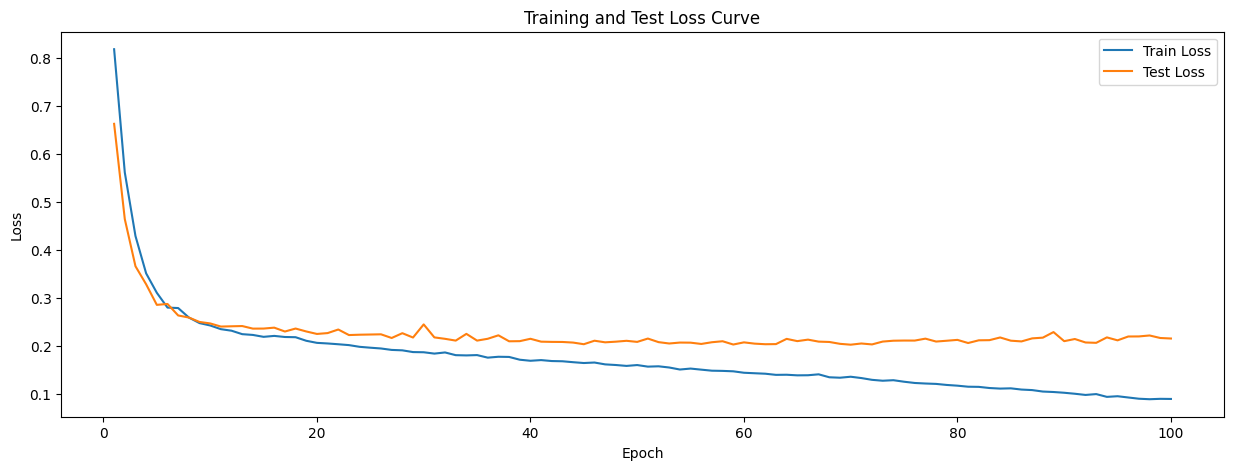

In [17]:
#Testing against the test dataset

model = Classifier(n_cont=len(cont_cols),
                   cat_feat=unique_classes_per_column,
                   targets_classes=[1],
                   rff_on=True,
                   sigma=2,
                   embed_size=160,
                   num_layers=5,
                   heads=1,
                   forward_expansion=8,
                   pre_norm_on=False,
                   mlp_scale_classification=8,
                   embedding_dropout=0.1,
                   decoder_dropout=0,
                   classification_dropout=0.1,
                   ).to(device_in_use) # Instantiate the model
loss_functions = UncertaintyLoss(1)
optimizer = torch.optim.Adam(params=model.parameters(), lr = .0001) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.
epochs = 100 #Set the number of epochs

print("Number of parameters: ", count_parameters(model))

train_losses = [] 
test_losses = []
lowest_mse = float('inf')

for t in range(epochs):
  train_loss, r2_train, rmse_train = train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, r2_test, rmse_test = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)
  
  # record train and test losses to plot
  train_losses.append(train_loss)
  test_losses.append(test_loss)

  # record lowest MSE
  if test_loss < lowest_mse:
    lowest_mse = test_loss

  # test_accuracies_2.append(test_accuracy_2)
  # test_recalls.append(test_recall)
  # test_f1_scores.append(test_f1)
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  train_metrics = f"Train: Loss {format_metric(train_loss)}, R2 {format_metric(r2_train)}, RMSE {format_metric(rmse_train)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)}, R2 {format_metric(r2_test)}, RMSE {format_metric(rmse_test)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")


torch.save(model.state_dict(), 'cat_model_trained.pth')

# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 1, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

print('Lowest MSE: ', {lowest_mse})
